# Decalration(声明)
本文翻译并细微调整自：[http://nlp.seas.harvard.edu/2018/04/03/attention.html](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

论文PDF下载地址：[https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)


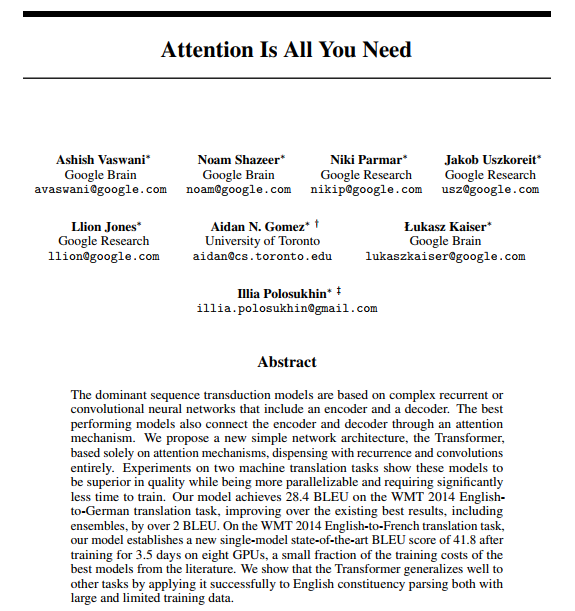

In [1]:
from IPython.display import Image
Image(filename='images/aiayn.png')

In [2]:
# 包导入
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# Transformer
Transformer 来自 “Attention is All You Need”，吸引了很多人的注意。除了提升了翻译的质量，还为NLP的其他任务提供了新的架构。论文写的很清楚，但是正确的实现很困难

这是一个通过一行一行的代码实现注释版本，我节选了论文中的部分，并补充了代码实现，整个论文包括了400行代码，可以每秒处理2700个token在4个GPU上。

文档目录结构：
模型结构
- Encoder and Decoder Stack(编码器和解码器堆栈)：Encoder（编码器），Decoder（解码器），Attention（注意力机制）
- Posion-wise Feed-Foward Networks（前馈神经网络）
- Embedding and Softmax（嵌入向量和Softmax）
- Positional Embedding（位置嵌入向量）
- Full Model（完整模型）

训练
- Batches and Masking （批处理与掩码）
- Training Loop （训练回合）
- Train Data and Batching（训练数据和批处理）
- Hardware and Schedule（硬件与安排）
- Optimizer（优化器）
- Regularization: Label Smoothing（标签平滑）

第一个例子
- Synthetic Data（合成数据）
- Loss Computation（损失函数）
- Greedy Decoding（贪婪解码）

一个真实的例子
- Data Loading（数据加载）
- Iterators（迭代）
- Multi-GPU Traning（多GPU训练）
- Training the system（系统训练）

## 背景
Extended Neural GPU, ByteNet 和 ConvS2S的共同目标之一是减少顺序计算带来的开销。这些模型均采用了CNN作为构建模块，从而实现对所有输入和输出位置的的隐含表示实现并行计算。在这些模型中，关联来自两个任意位置的输入的开销随着位置间的距离增长，其中ConvS2S呈线性增长，ByteNet呈对数级增长。这使得学习远距离位置之间的依赖关系更加困难。但是在Transformer中这一开销被降到了常数级别。为了弥补注意力机制关注所有位置导致的细粒度能力下降，我们引入了多头注意力机制（Multi-head Attention）进行弥补。

自注意力机制（Self-Attention）有时又被称为内部注意力机制（intra-attention）， 是一种通过关联单句中不同位置的注意力机制，用来计算产生句子的表示。自注意力机制被成功的运用到了一些列任务重，包括阅读理解，摘要总结，文本蕴含和学习任务无关的句子表示。

## 模型结构
多数性能优异的神经序列转换模型都采用了encoder-decoder的结构。这里encoder将一个输入序列$(x_1,\ldots, x_n)$映射到一个连续的表示空间$\mathbf{z}=(z_1,\ldots,z_n)$。再通过z,同时解压输出序列$(y_1,\ldots,y_n)$。在每一步，模型都是自回归的，将前一步的生成作为当前生成的输入。

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

Transformer 如图左侧和右侧所示，将叠加的自注意力机制（self-attention），位置逐位前馈神经网络（point-wise feed forward）应用在编码器（encoder）和解码器（decoder）中。


![](images/transformer.png)

## 编码器和解码器栈（Encoder and Decoder Stacks）
### 编码器（Encoder）
Encoder 由$N=6$个相同结构的层组成。

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        """
        x:b,s,d
        mask:b,1,s # batch, query length(1 for expand), key length
        """
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

我们在两个子层之间使用残差连接，并随后采用层归一化。

In [7]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

每一个子层的输出都是LayerNorm(x+Sublayer(x))，其中Sublayer(x)在dropout之后，会作为残差加回到x。

为了方便这些残差连接，所有的子层和嵌入层都采用了维度$d_{model}=512$。

译者注：论文中使用的是后归一化：LayerNorm(x+Sublayer(x))，本Notebook中编码器和解码器先采用了前归一化：x+Sublayer(LayerNorm(x))，最后再套了一个LayerNorm(x+Sublayer(LayerNorm(x)))，相当于先对输入进行LayerNorm，再采用后归一化。

In [8]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


每一个编码器层都有两个子层：
- 第一个子层是多头自注意力机制（multi-head self-attention)。
- 第二个子层是简单的位置逐位全连接前馈神经网络（position-wise fully connected feed-forward network)。

In [9]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """
        x:b,s,d
        mask:b,1,s # batch, query length(1 for expand), key length
        """
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## 解码器（Decoder）
Decoder同样由$N=6$个相同结构的层组成。

In [10]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        x: b,t,v
        m: b,s,v
        src_mask: b,1,s # batch, query length(1 for expand), key length
        tgt_mask: b,t,t # batch, query length(differnt mask for each query, can't expand), key length
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

除了编码器（Encoder）的两个子层之外，解码器（Decoder）还插入了第三个子层，这个子层负责在编码器的输出上进行多头注意力机制。与编码器一样，每个子层之后输出之后都有残差连接和层归一化。

In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        x: b, t, v
        memory: b, s, v
        src_mask: b, 1, s # batch, query length(1 for expand), key length (src key)
        tgt_mask: b, t, t # batch, query length(differnt mask for each query, can't expand), key length (tgt key)
        """
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

我们在修改了解码器栈（decoder stack）中的自注意力（self-attention）子层，防止注意力机制中的查询特征关注到了其后续的位置上的单词信息（当前阶段还是未知的）。

In [12]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [13]:
subsequent_mask(5)

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

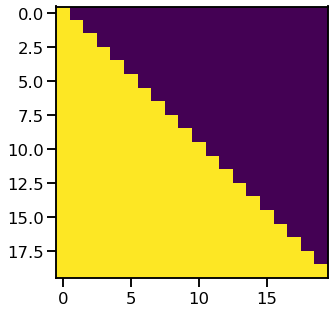

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

## 注意力机制（Attention）
注意力机制可以被描述为将一个查询（query)和一个由很多键值对(key-value pairs)组成的集合，映射到一个输出。其中query，keys，values和output都是向量。输出（output）是由values组成的加权和，权重是由query和相应的key之间的相似性（compatibility）计算得到的。

我们叫这种特殊的注意力机制是缩放点积注意力机制“Scaled Dot-Product Attention”。 输入的queries和keys的维度是$d_k$, values的维度是$d_v$。我们在计算query和key的点乘结果之后，要除以$\sqrt{d_k}$。随后通过softmax函数来获取在values上的权重。

![](images/scaled_attention.png)

在实践中，我们同时处理query集合Q，key集合K，value集合V，我们定义output结合为：
$$
\mathrm{Attention}(Q,K,V)=\mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

In [15]:
def attention(query, key, value, mask=None, dropout=None):
    """
    query: b,h,l,d_h
    key: b,h,k,d_h
    value: b,h,k,d_h
    mask: 
        b,1,1,s in encoder self_attn
        b,1,1,s in decoder src_attn
        b,1,t,t in decoder self_attn
        b,h,l,m in General: batch, headnumber, sequence length (query), mask for each position in length (key/value)
    return:
        b,h,l,d_h
        b,h,l,k
    """
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

最常用的两种注意力机制（attention）是加性注意力（additive attention）和点积注意力（dot-product attention）。我们这里采用了点积注意力，并且采用了缩放尺度$\frac{1}{\sqrt{d_k}}$。加性注意力计算相似性（Compatibility）时使用单隐层前馈网络。虽然两者在理论上拥有相似的计算复杂度，但是点积注意力在实际中更加的快速和空间有效，因为它可以采用矩阵乘法。

对于小数值的$d_k$，两种注意力机制效果相似，但是当$d_k$变大时，点积注意力机制的效果就变差，我们猜测是由于维度变大带来点积数值的变大，将softmax推向了梯度更小的区域（为了说明dot product为什么变大，我们假设q和k是独立的均值为0和方差为1的变量，点积的均值为0，方差为$\sqrt{d_k}$），为了减轻这种影响，我们将点积乘以$\frac{1}{\sqrt{d_k}}$,成为缩放点积注意力。（译者注：具体解释可参考[https://kexue.fm/archives/8620](https://kexue.fm/archives/8620) ）

In [16]:
def meausre_experiment(d=10):
    results=[]
    for i in range(10000):
        q = np.random.normal(loc=0.0, scale=1.0, size=(d))
        k = np.random.normal(loc=0.0, scale=1.0, size=(d))
        results.append(np.dot(q,k))
    dot_std = np.std(results)
    scaled_dot_std = dot_std/np.sqrt(d)
    print("dimension:{}, dot_std:{:.3f},scaled_dot_std:{:.3f}".format(d, dot_std, scaled_dot_std ))
meausre_experiment(1)
meausre_experiment(10)
meausre_experiment(100)
meausre_experiment(10000)

dimension:1, dot_std:0.988,scaled_dot_std:0.988
dimension:10, dot_std:3.174,scaled_dot_std:1.004
dimension:100, dot_std:10.071,scaled_dot_std:1.007
dimension:10000, dot_std:100.514,scaled_dot_std:1.005


![](images/multi_head.png)

多头注意力机制（Multi-head attention) 允许模型联合关注其在不同子空间中的分别表示。单头的注意力机制，没有办法做到这一点
$$
\mathrm{MulitiHead}(Q,K,V)=\mathrm{Concat}(head_1,\ldots,head_h)W^O
$$
其中
$$
head_i=\mathrm{Attention}(QW_i^Q,KW_i^K,VW_i^V)
$$
其中参数的维度如下
$$
W_i^Q \in \mathbb{R}^{d_{model} \times d_k}, W_i^K \in \mathbb{R}^{d_{model} \times d_k}, W_i^V \in \mathbb{R}^{d_{model} \times d_v} , W^O \in \mathbb{R}^{h d_v \times d_{model}}
$$
在本文中，我们设置$h=8,d_k=d_v=d_{model}/h=64$，由于每个注意力头的维度都缩小了，整体开销同全维度的单头注意力机制开销是差不多的。

In [17]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """
        query: b, q, d
        key: b, k, d
        v: b, k, d
        mask:
            b,1,s in encoder
            b,t,t in decoder self_attn
            b,1,s in decoder src_attn
        return:
            b,q,d
        """
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
            # in decoder self_attn: b,1,t,t: add head dimension
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k (query: b,q,d_model->b,h,q,d_k)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. b,h,q,d_k -> b,q,h,d_k -> b,q,h*d_k
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# 多头注意力机制在模型中的应用
Transformer以3种方式使用multi-head attention：
1. 在编码器解码器注意力层（encoder-decoder attention），query来自前一层的解码器（decoder）的输出，key和value来自编码器（encoder）的输出。这样，解码器（decoder）中的每个输出都包含了来自输入的所有位置的信息。
2. 在编码器（encoder）层中包含了自注意力层（self-attention）层，query，key，value都来自前一个encoder层的输出，每一个位置的信息都包含了前一encoder层的所有位置信息。
3. 在解码器（decoder）层中也包含了自注意力机制，允许每个位置关注当前位置和它之前的位置。这里要防止信息向左流动，来保持自回归属性。我们通过在缩放点击注意力机制（scaled dot-product attention）中使用掩码（mask）来屏蔽softmax输入中所有无效的相似度。

## 位置逐位前馈神经网络层（Position-wise Feed-Foward Networks）
在注意力机制子层之上，我们的编码器（encoder）和解码器（decoder）层在每个位置上都包括了一个独立且相同的全连接前馈层，包含了两个线性层和一个ReLU激活层。
$$
FFN(X)=max(0,xW_1+b_1)W_2 + b_2
$$
译者注：位置逐位前馈神经网络相当于将单隐层的MLP网络应用到（B,L,D)中的每一个（B，D）上，即不同位置上的词向量独立使用同一个MLP。B表示batch size，L表示序列长度，D表示向量维度。

虽然线性变换在每个位置上都是相同的，但是在不同层之间，线性变换是不同的，换一种方式描述，就是使用两个核为1的卷积层，输入输出的维度是$d_{model}=512$，中间层的维度是$d_{ff}=2048$

In [18]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 词嵌入层（Embeddings）和 Softmax
同大多数其他顺序转换模型相似，我们使用学习得到的词嵌入层（embedding）去转化输入tokens和输出tokens到维度为$d_{model}$的向量。
我们也使用学习到的线性变换和softmax函数来转换解码器（decoder）的输出，去预测下一个token的概率。在我们的模型中，我们在词嵌入层（embedding）和pre-softmax的线性变换中使用相同的权重矩阵（weight matrix）。
在词嵌入层中，我们用$\sqrt{d_{model}}$乘权重（weights）。

In [19]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码（Postional Encoding）
因为我们的模型不包含递归和卷积网络，为了能够让模型使用序列的位置信息，我们必须注入位置信息到序列的token中。考虑到这一点，我们加入位置编码（postional encodings）到输入的词嵌入向量（embedding）中。位置编码向量与词嵌入向量拥有相同的维度$d_{model}$，这样它们就可以相加。有很多位置编码（学习的和固定的）可以选择，这里我们采用了不同频率上的正弦和余弦函数
$$
PE_{pos,2i}=sin(\frac{pos}{10000^\frac{2i}{d_{model}}}) \\
PE_{pos,2i+1}=cos(\frac{pos}{10000^\frac{2i}{d_{model}}})
$$
其中pos是序列位置序号信息，i是维度序号。也就是说每一个维度对应了一条正弦函数，其波长为从$2\pi$到$10000\cdot 2\pi$的等比序列。我们采用这种表示的原因是，它容易学习到如何关注相对位置信息，对于固定的偏差k，可以表示为固定的线性变换$f_L$，$PE_{pos+k}=f_L(PE_k)$。

此外，我们对编码器（encoder)栈和解码器（decoder）栈中输入的向量和（词向量+位置编码向量）进行dropout操作。

In [20]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

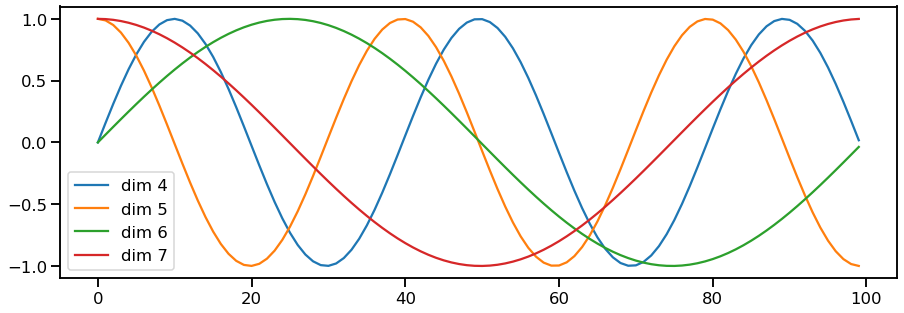

In [21]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

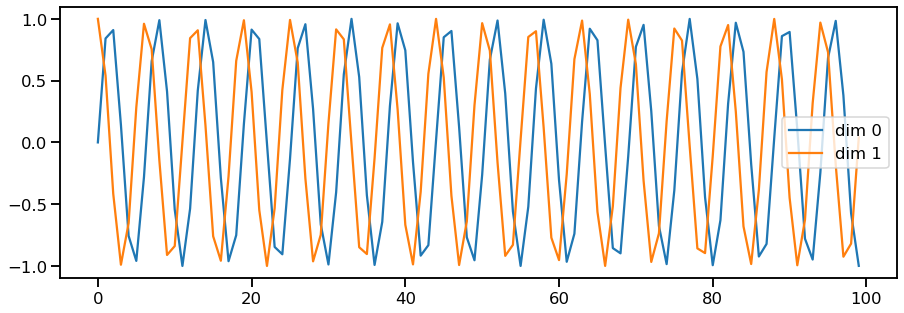

In [22]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 0:2].data.numpy())
plt.legend(["dim %d"%p for p in [0,1]])
None

我们同样采用了基于学习的位置嵌入编码（position embedding），两者的效果差不多。我们选择这种正弦编码方式，因为它能够让我们在测试时，可以编码比我们在训练时更长的位置信息。

## 完整的模型

In [23]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [24]:
# Small example model.
tmp_model = make_model(10, 10, 2)
None


# 训练
## Batches and Masking

In [25]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        """
        src: b,s
        trg: b,t
        """
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2) #add query dimension(for expand) b,1,t
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)) # 1,t,t
        return tgt_mask

## 训练回合

In [26]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 优化器
我们采用了Adam优化器，其中$\beta_1=0.9$, $\beta_2=0.98$并且$\epsilon=10^{-9}$。学习率采用了如下计算公式:
$$
lr = d_{model}^{-0.5}\min(step\text{_}num^{-0.5}, step\text{_}num \cdot warmup\_steps^{-1.5})
$$

In [27]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

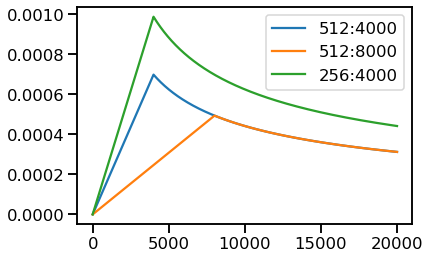

In [28]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## 正则化
### 标签平滑
在训练过程中，我们采用了标签平滑，其中$\epsilon_{ls}=0.1$。标签平滑会带来更多的不确定性，因此影响困惑度指标，但是会提升精度和BLEU分数。

In [29]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2)) # 2: expert pad and target label index
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # confidence for target
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0) # padding
        self.true_dist = true_dist
        x = torch.clamp(x, min=-1e10)
        return self.criterion(x, Variable(true_dist, requires_grad=False)) #log_probability

/Users/sunq/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


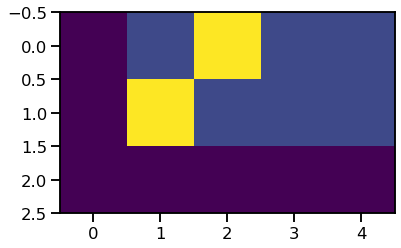

In [30]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

当模型对预测结果非常确定时，标签平滑会产生惩罚效果。

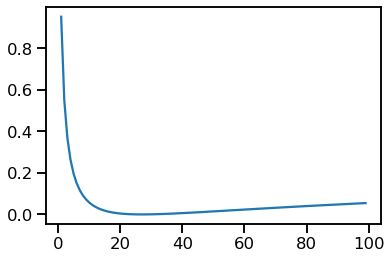

In [31]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# 一个简单的例子
我们通过一个简单的拷贝任务开始，随机产生一个序列，任务目标是重新生成相同的序列。

## 合成数据

In [32]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## 损失函数定义

In [33]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm

## 模型训练

In [34]:
# 在简单拷贝任务上进行训练
V = 11 # 词汇量
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2) # 模型只有两层
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/Users/sunq/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch Step: 1 Loss: 3.293485 Tokens per Sec: 1566.547729
Epoch Step: 1 Loss: 1.961681 Tokens per Sec: 3272.964600
tensor(1.9784)
Epoch Step: 1 Loss: 1.992656 Tokens per Sec: 2096.843262
Epoch Step: 1 Loss: 1.656127 Tokens per Sec: 3354.305176
tensor(1.6637)
Epoch Step: 1 Loss: 1.806720 Tokens per Sec: 2072.282715
Epoch Step: 1 Loss: 1.512314 Tokens per Sec: 2667.327881
tensor(1.5439)
Epoch Step: 1 Loss: 1.729204 Tokens per Sec: 1472.778442
Epoch Step: 1 Loss: 1.374281 Tokens per Sec: 2950.353271
tensor(1.3568)
Epoch Step: 1 Loss: 1.370382 Tokens per Sec: 1873.790894
Epoch Step: 1 Loss: 1.161923 Tokens per Sec: 3059.579590
tensor(1.1522)
Epoch Step: 1 Loss: 1.248220 Tokens per Sec: 1972.069824
Epoch Step: 1 Loss: 0.762652 Tokens per Sec: 2748.497559
tensor(0.7785)
Epoch Step: 1 Loss: 0.837119 Tokens per Sec: 1653.489990
Epoch Step: 1 Loss: 0.447070 Tokens per Sec: 2958.658691
tensor(0.4495)
Epoch Step: 1 Loss: 0.651442 Tokens per Sec: 1925.510620
Epoch Step: 1 Loss: 0.388641 Tokens per 

## 贪婪解码
简单起见，直接采用贪婪算法进行解码。

In [35]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  5,  8,  9, 10]])


## 可视化

Encoder Layer 1


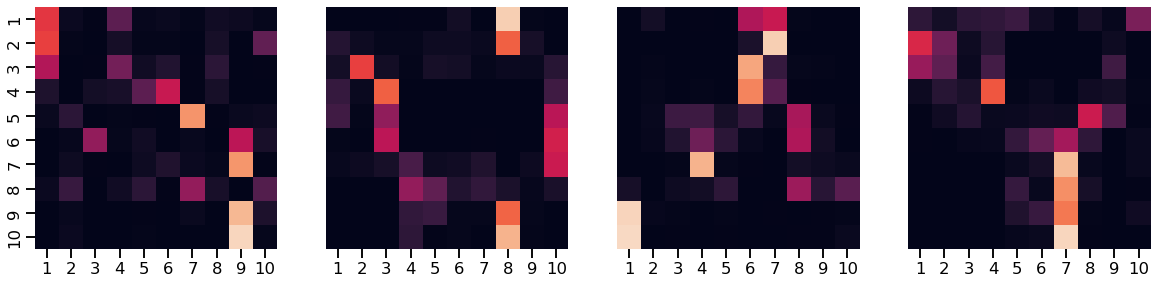

Encoder Layer 2


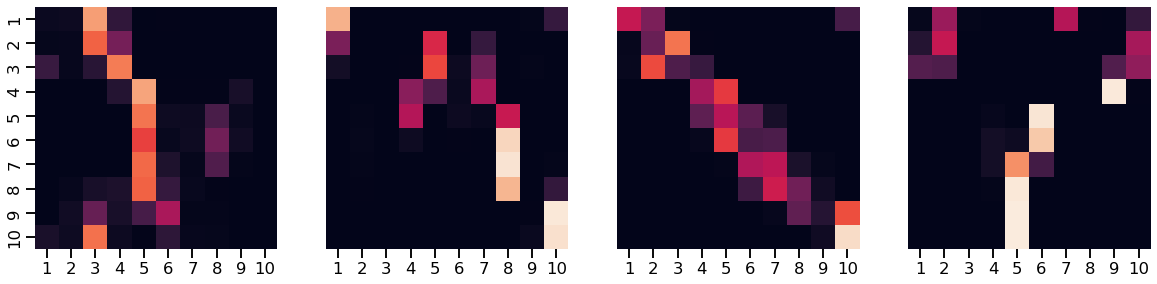

Decoder Self Layer 1


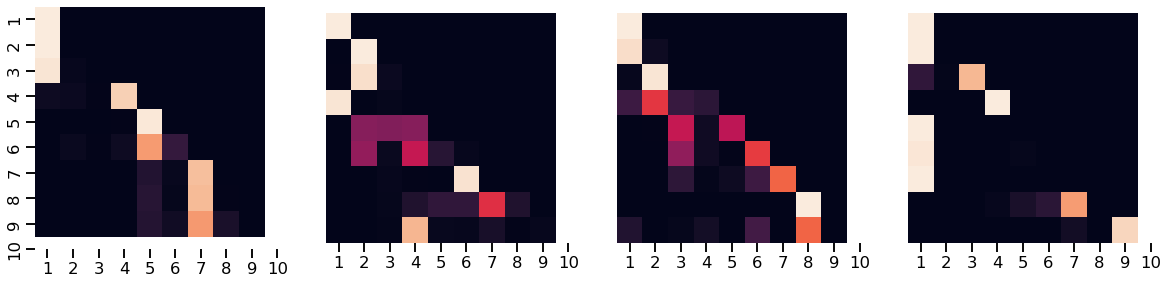

Decoder Src Layer 1


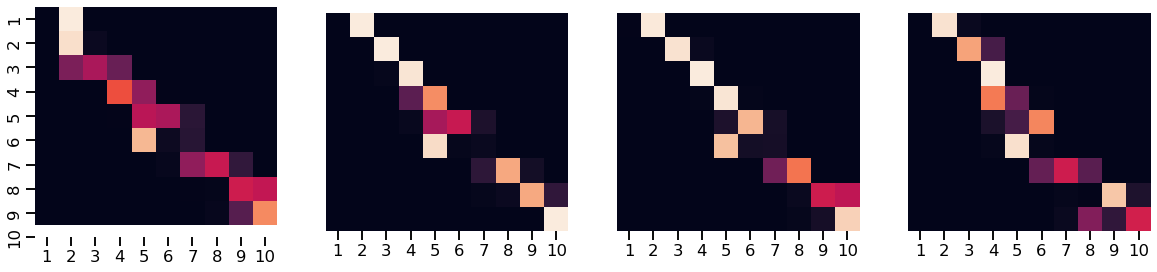

Decoder Self Layer 2


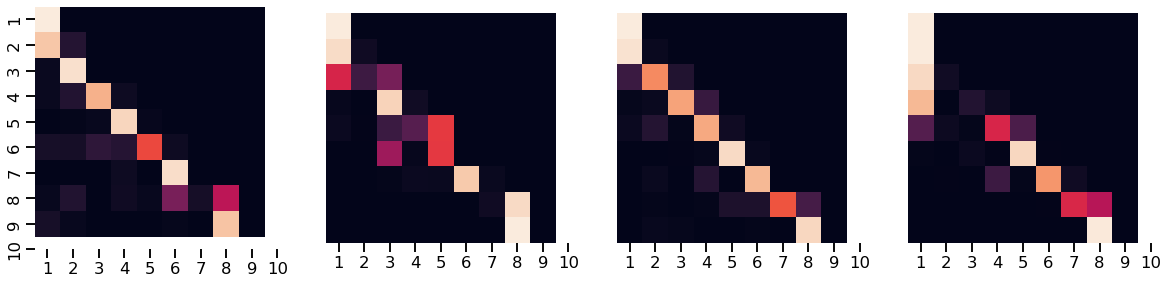

Decoder Src Layer 2


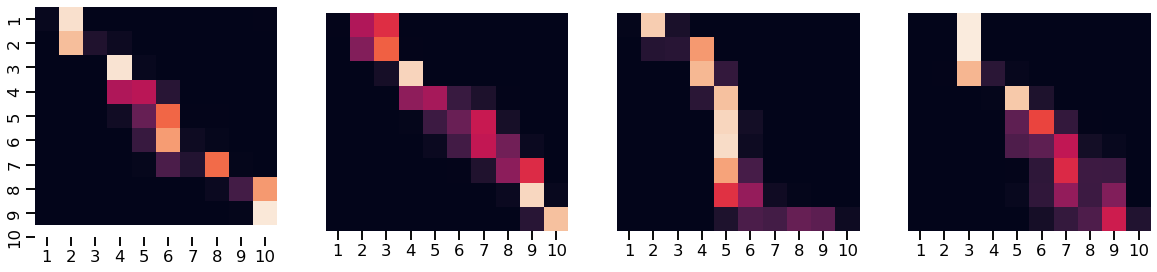

In [36]:
sent = [1,2,3,4,5,6,7,8,9,10]
tgt_sent = [1,2,3,4,5,6,7,8,9,10]
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(0, 2, 1):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].src_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()